In [1]:
import sys
import os
import toml

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import scipy.optimize as SciOpt
from scipy.special import rel_entr
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm
from copy import deepcopy

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.data_generators import DataGenerator
from lsm.lsmtype import Policy
import lsm.cost as CostFunc
import lsm.solver as Solvers

In [20]:
config = Reader.read_config('../../endure.toml')
data_gen = DataGenerator(config)
wls = config['workloads']

In [21]:
def get_nominal_tunings(workload):
    solvers = {
        'Y1': Solvers.EndureYSolver(config, last_level=1),
        'YZ': Solvers.EndureYZSolver(config),
        'Q': Solvers.EndureQSolver(config),
        'K': Solvers.EndureKSolver(config),
        'Tier': Solvers.EndureTierSolver(config),
        'Level': Solvers.EndureLevelSolver(config)}
    z0, z1, q, w = workload
    tunings = {}
    for label, solver in solvers.items():
        design = solver.find_nominal_design(z0, z1, q, w) 
        tunings[label] = {
            'design': design,
            'solver': solver}
    return tunings

In [22]:
def sample_workloads(samples=10000):
    wls = []
    for _ in range(samples):
        wls.append(data_gen._sample_workload(4))
    return wls

def kl_div(w0: np.array, w1: np.array):
    return np.sum(rel_entr(w0, w1))

In [23]:
def gen_workloads(w0: np.array) -> pd.DataFrame:
    samples = sample_workloads()
    distances = []
    for sample in samples:
        distances.append(
            {'workload': sample,
             'rho': kl_div(sample, w0)})
        
    return pd.DataFrame(distances)

In [101]:
def calc_objective(key, design, workload):
    max_levels = config['lsm']['max_levels']
    s = Solvers.EndureKSolver(config)
    if key == 'Y1':
        x = np.concatenate((design[0:2], (max_levels - 1) * [design[2]], [1]))
    elif key == 'YZ':
        x = np.concatenate((design[0:2], (max_levels - 1) * [design[2]], [design[3]]))
    elif key == 'Q':
        x = np.concatenate((design[0:2], max_levels * [design[2]]))
    elif key == 'K':
        x = design
    elif key == 'Tier':
        x = np.concatenate((design, max_levels * [design[1]]))
    elif key == 'Level':
        x = np.concatenate((design, max_levels * [1]))
    z0, z1, q, w = workload
    return s.nominal_objective(x, z0, z1, q, w)

In [197]:
def gen_costs(
    w0: np.array,
    workloads: list[list[float]],
    tunings: dict[str, dict]
) -> pd.DataFrame:
    df = []
    for wl in workloads:
        z0, z1, q, w = wl
        row = {'rho': kl_div(wl, w0), 'z0': z0, 'z1': z1, 'q': q, 'w': w}
        for key, val in tunings.items():
            row[key] = calc_objective(key, val['design'].x, wl)
            # row[key] = val['solver'].nominal_objective(val['design'].x, z0, z1, q, w)
        df.append(row)
    # Special case we will add our orignal
    z0, z1, q, w = w0
    row = {'rho': 0, 'z0': z0, 'z1': z1, 'q': q, 'w': w}
    for key, val in tunings.items():
        row[key] = calc_objective(key, val['design'].x, w0)
        # row[key] = val['solver'].nominal_objective(val['design'].x, z0, z1, q, w)
    df.append(row)
    return pd.DataFrame(df)

In [224]:
idx = 4
workload = np.array([wls[idx][key] for key in ('z0', 'z1', 'q', 'w')])
tunings = get_nominal_tunings(workload)
df = gen_costs(workload, sample_workloads(), tunings)

In [225]:
rho_bins = np.arange(0.1, 4.5, 0.1)
rho_bins = list(zip(rho_bins, rho_bins[1:]))

mean = []
for low, high in rho_bins:
    mean.append(df[(df.rho > low) & (df.rho <= high)].mean().to_dict())
# mean.append(df.iloc[-1].to_dict())
mean = pd.DataFrame([df.iloc[-1].to_dict()] + mean)

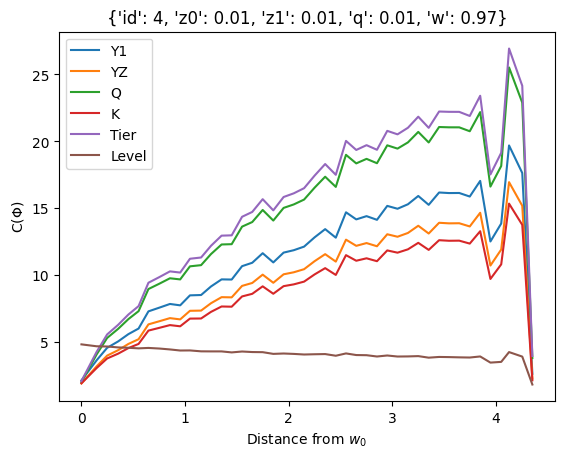

In [226]:
fig, ax = plt.subplots()
for key in tunings.keys():
    ax.plot(mean['rho'], mean[key], label=f'{key}')
ax.set_xlabel('Distance from $w_0$')
ax.set_ylabel('C($\Phi$)')
ax.set_title(f'{wls[idx]}')
_ = ax.legend()

In [232]:
def create_and_plot(idx=0):
    workload = np.array([wls[idx][key] for key in ('z0', 'z1', 'q', 'w')])
    tunings = get_nominal_tunings(workload)
    df = gen_costs(workload, sample_workloads(), tunings)
    
    rho_bins = np.arange(0.1, 4.5, 0.1)
    rho_bins = list(zip(rho_bins, rho_bins[1:]))

    mean = []
    for low, high in rho_bins:
        mean.append(df[(df.rho > low) & (df.rho <= high)].mean().to_dict())
    mean = pd.DataFrame([df.iloc[-1].to_dict()] + mean)
    
    fig, ax = plt.subplots()
    for key in tunings.keys():
        ax.plot(mean['rho'], mean[key], label=f'{key}')
    ax.set_xlabel('Distance from $w_0$')
    ax.set_ylabel('C($\Phi$)')
    ax.set_title(f'{wls[idx]}')
    _ = ax.legend()
    
    return df, mean, fig, ax

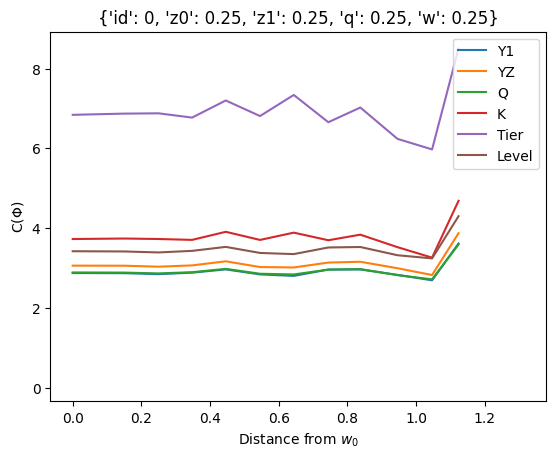

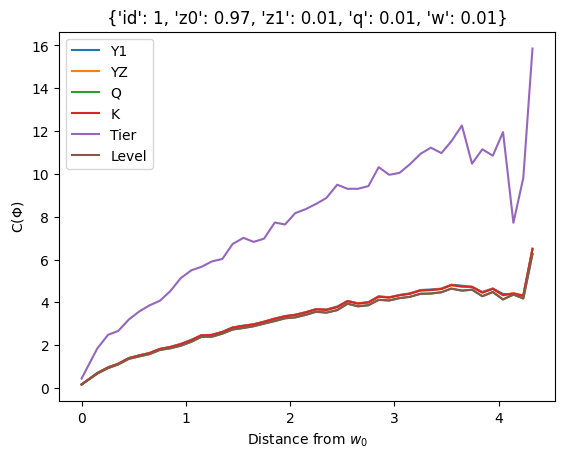

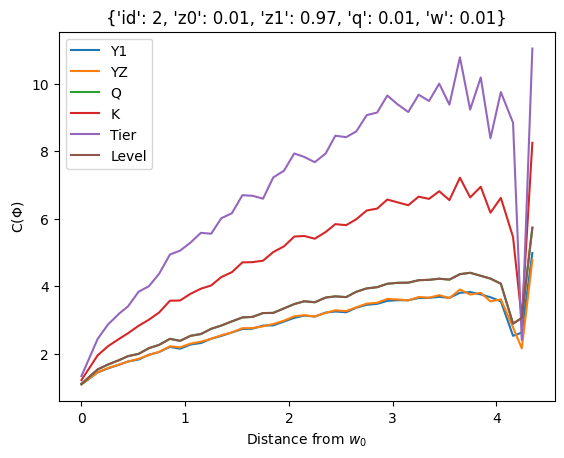

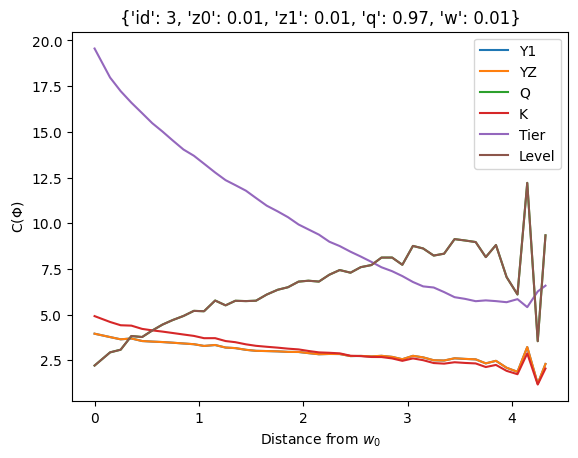

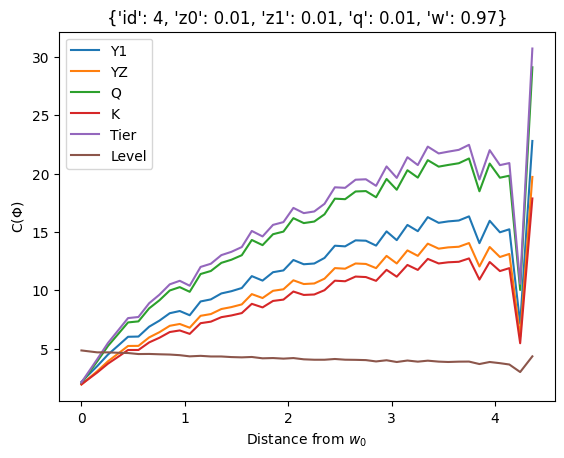

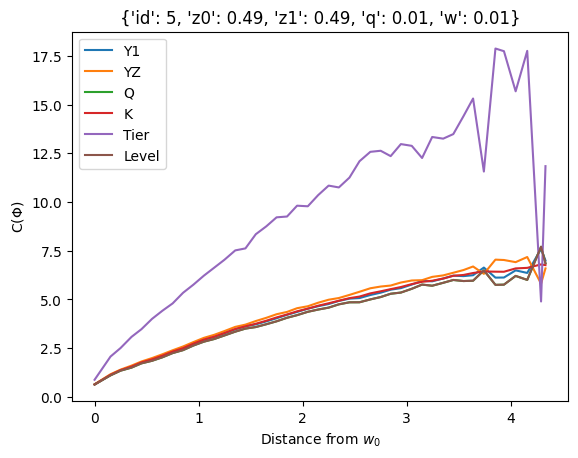

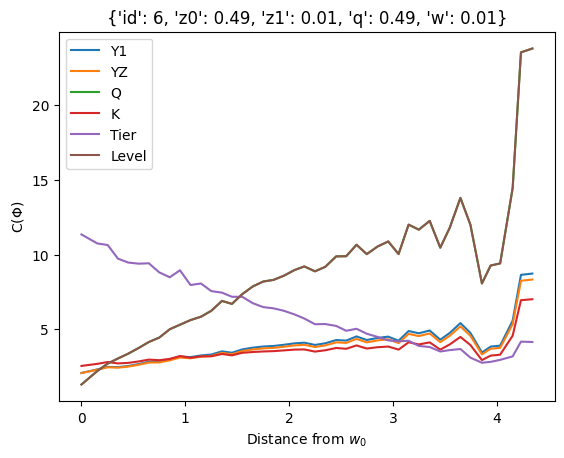

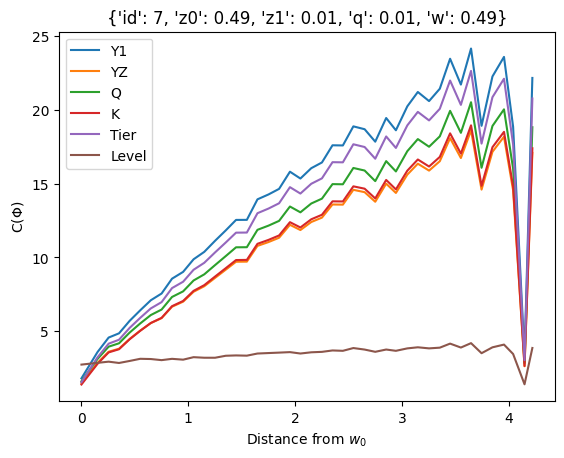

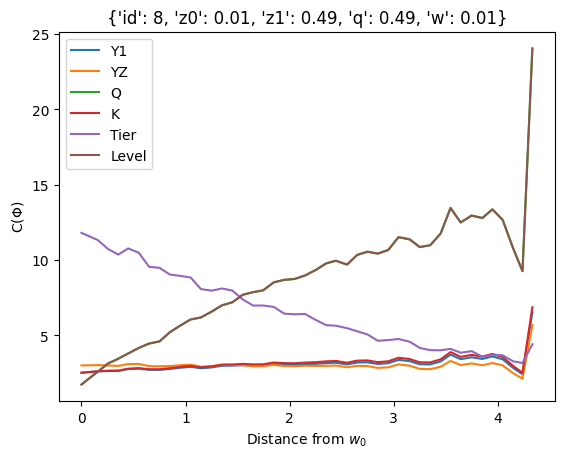

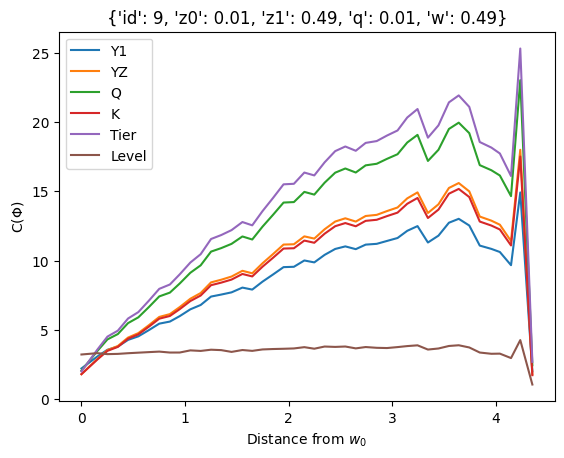

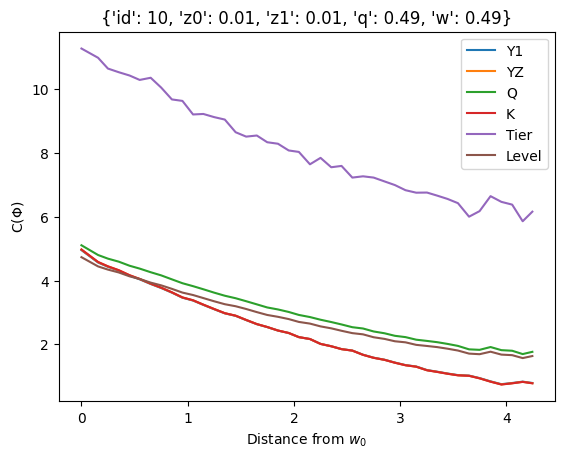

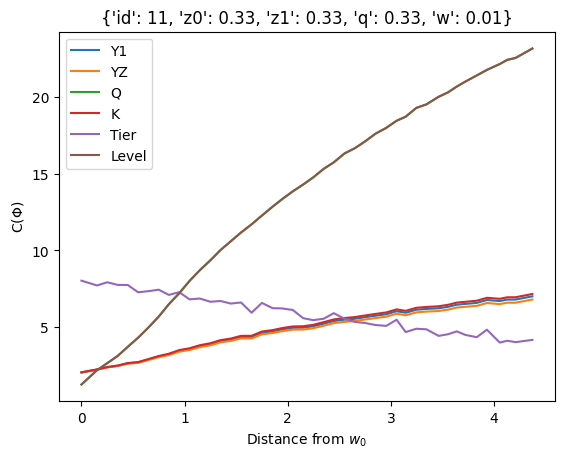

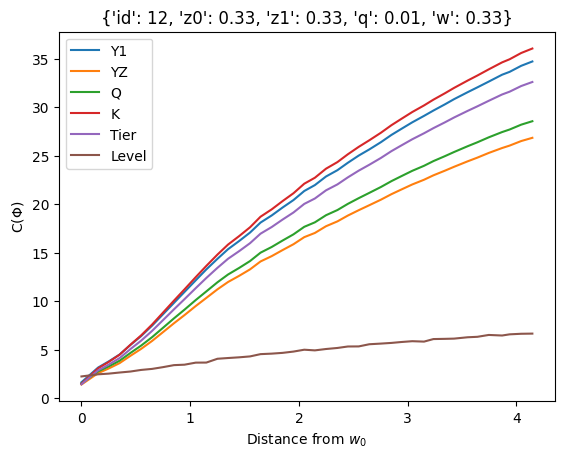

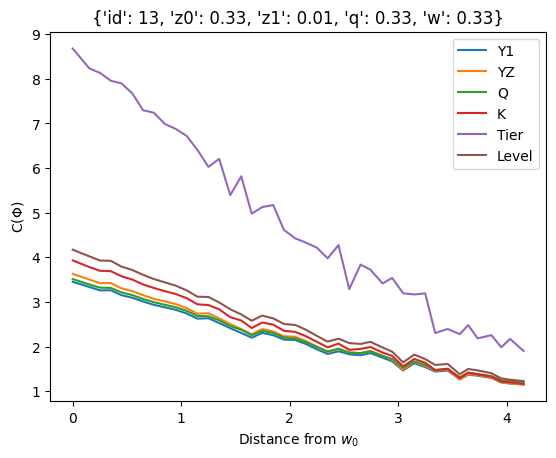

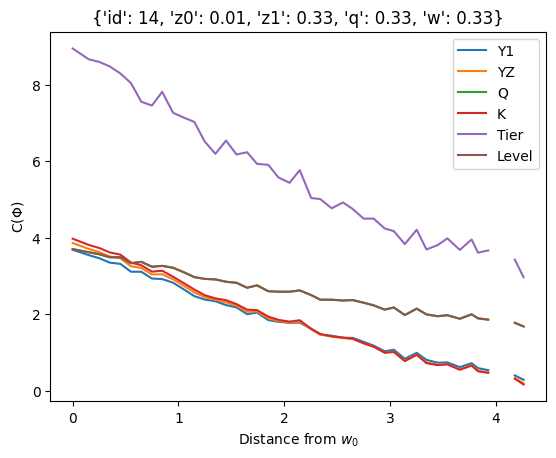

In [236]:
for idx, wl in enumerate(wls):
    _, _, fig, ax = create_and_plot(idx=idx)
    fig.savefig(f'wl_{idx}.pdf')

In [214]:
for key, val in tunings.items():
    print(f'{key}: {val["design"].x}')

Y1: [6.02036627 6.73657954 1.        ]
YZ: [6.30919123 4.66974111 1.         1.        ]
Q: [ 0. 50.  1.]
K: [6.7483191 7.0853873 1.        1.        1.        1.        8.
 8.        8.        8.        8.        8.        8.        8.
 8.        8.        8.        8.       ]
Tier: [2.58321849 2.        ]
Level: [ 0. 50.]
